In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler

closes = pd.read_csv('../raw_data/closes.csv', index_col='timestamp', parse_dates=True)
series = TimeSeries.from_dataframe(closes).astype(np.float32)
apple = series.univariate_component('AAPL')
train, val = apple.split_after(0.8)
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


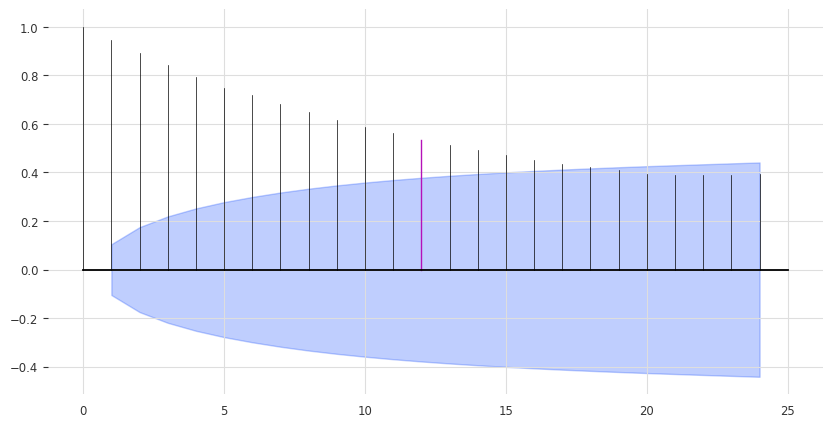

In [40]:
from darts.utils.statistics import plot_acf, check_seasonality



plot_acf(train, m=12, alpha=0.05);

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

# RNN

In [41]:
from darts.models import RNNModel

model = RNNModel(
    input_chunk_length=24,
    model='LSTM',
    hidden_dim=20,
    n_rnn_layers=4,
    #training_length=52
)

model.fit(train_scaled, verbose=True, epochs=25)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 11.9 K
4 | V             | Linear           | 21    
---------------------------------------------------
11.9 K    Trainable params
0         Non-trainable params
11.9 K    Total params
0.048     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=4, dropout=0.0, training_length=24, input_chunk_length=24)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='timestamp'>

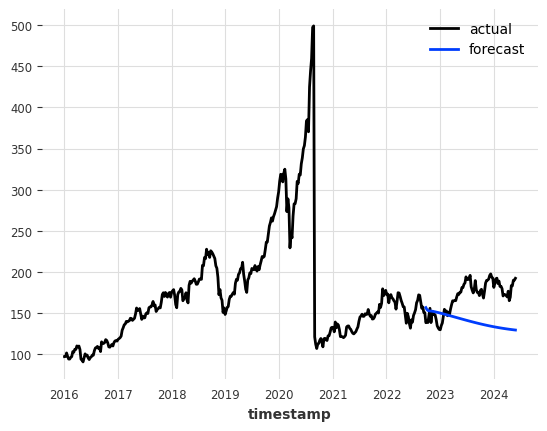

In [42]:
pred_series = model.predict(n=len(val))
pred_series = scaler.inverse_transform(pred_series)
apple.plot(label='actual')
pred_series.plot(label='forecast', lw=2)

## Evalute

In [43]:
baseline_mae = np.mean(np.abs(val.values() - train.last_value()))
print(f'Baseline MAE: {baseline_mae:.5f}')

Baseline MAE: 23.75807


In [44]:
from darts.metrics import mape, mae

print(f'MAPE: {mape(val, pred_series):.2f}%')
print(f'MAE: {mae(val, pred_series):.5f}')

MAPE: 19.06%
MAE: 33.96655


# N-BEATS

In [46]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=12, output_chunk_length=1, random_state=42)

model.fit(train_scaled, epochs=50, verbose=True);

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.1 M 
---------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.402    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='timestamp'>

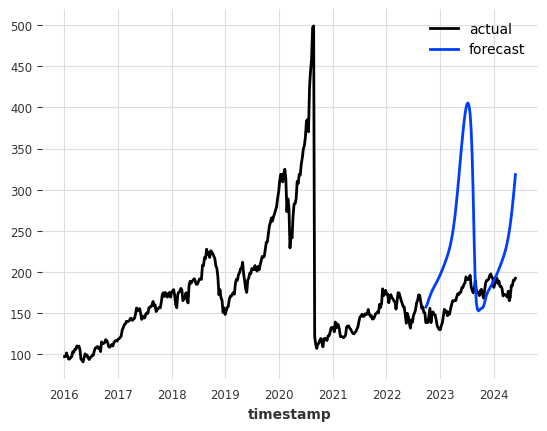

In [47]:
pred_series = model.predict(n=len(val))
pred_series = scaler.inverse_transform(pred_series)
apple.plot(label='actual')
pred_series.plot(label='forecast', lw=2)

In [48]:
from darts.metrics import mape, mae

baseline_mae = np.mean(np.abs(val.values() - train.last_value()))
print(f'Baseline MAE: {baseline_mae:.5f}')
print(f'MAPE: {mape(val, pred_series):.2f}%')
print(f'MAE: {mae(val, pred_series):.5f}')

Baseline MAE: 23.75807
MAPE: 40.91%
MAE: 70.14471


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='timestamp'>

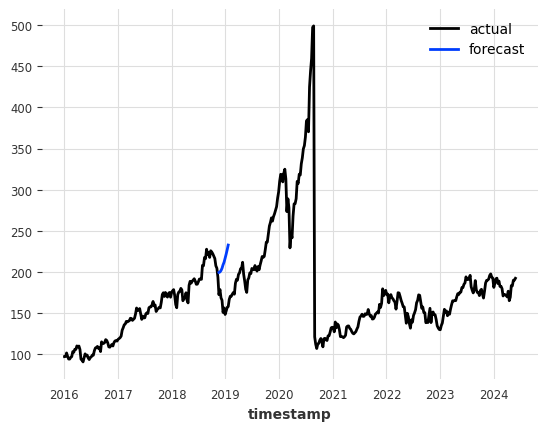

In [49]:
pred_series = model.predict(series = train_scaled[:150], n=10)
pred_series = scaler.inverse_transform(pred_series)
apple.plot(label='actual')
pred_series.plot(label='forecast', lw=2)